In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import RFE , f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import joblib

In [2]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
import math
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Reshape
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [3]:

df_train = pd.read_csv('dataset/Training.csv')
df_test = pd.read_csv('dataset/Testing.csv')
df_eksternal = pd.read_csv('dataset/data2.csv')
df_temp = pd.concat([df_train, df_test], ignore_index=True)
df = pd.concat([df_temp, df_eksternal], ignore_index=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3536 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               3536 non-null   int64  
 1   Glucose                   3536 non-null   int64  
 2   BloodPressure             3536 non-null   int64  
 3   SkinThickness             3536 non-null   int64  
 4   Insulin                   3536 non-null   int64  
 5   BMI                       3536 non-null   float64
 6   DiabetesPedigreeFunction  3536 non-null   float64
 7   Age                       3536 non-null   int64  
 8   Outcome                   3536 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 248.8 KB


In [4]:
# Replace zero with NaN in some columns
cols_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace] = df[cols_to_replace].replace(0, np.nan)
df.isnull().sum()

Pregnancies                    0
Glucose                       23
BloodPressure                163
SkinThickness               1037
Insulin                     1707
BMI                           46
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
dtype: int64

In [5]:
# metode interpolate
df = df.interpolate(method='linear', limit_direction='both')
print(df.isnull().sum())
df.dropna(inplace=True)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
def remove_outliers_iqr(df, target_column=None):
    if target_column:
        features = df.drop(columns=[target_column])
    else:
        features = df.copy()
        
    Q1 = features.quantile(0.25)
    Q3 = features.quantile(0.75)
    IQR = Q3 - Q1

    # Mask: data yang TIDAK outlier
    mask = ~((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)

    # Gabungkan kembali kolom target kalau ada
    if target_column:
        return df.loc[mask]
    else:
        return features.loc[mask]

In [7]:
# Feature and label
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Menggabungkan fitur dan target
df_full = pd.concat([X, y], axis=1)

# Hapus outlier
df_no_outlier = remove_outliers_iqr(df_full, target_column="Outcome")

# Pisahkan kembali
X = df_no_outlier.drop("Outcome", axis=1)
y = df_no_outlier["Outcome"]

print(f"Data sebelum: {len(df_full)}")
print(f"Data setelah hapus outlier: {len(df_no_outlier)}")



Data sebelum: 3536
Data setelah hapus outlier: 3072


In [8]:
# Log transform
cols_to_log = ["Insulin", "DiabetesPedigreeFunction", "Age", "Pregnancies"]
for col in cols_to_log:
    X[col] = np.log1p(X[col])

# Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Reshape for CNN: (samples, height, width, channels)
n_features = X.shape[1]
target_size = math.ceil(np.sqrt(n_features)) ** 2  # cari kuadrat sempurna terdekat
padding_needed = target_size - n_features


# Tambahkan kolom dummy
for i in range(padding_needed):
    X[f'dummy_{i}'] = 0

# Normalisasi & reshape
X_scaled = scaler.fit_transform(X)
side_len = int(math.sqrt(target_size))  # sisi matriks (misal 3 utk 9 fitur)
X_reshaped = X_scaled.reshape(-1, side_len, side_len, 1)

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [11]:
# Build CNN model
model = Sequential([
    InputLayer(input_shape=(side_len, side_len, 1)),
    Conv2D(32, kernel_size=(2, 2), activation='relu'),
    MaxPooling2D(pool_size=(1, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=5,             
    restore_best_weights=True
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100


123/123 [==============================] - 1s 4ms/step - loss: 0.5436 - accuracy: 0.7191 - val_loss: 0.4589 - val_accuracy: 0.7622
Epoch 2/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.7542 - val_loss: 0.4593 - val_accuracy: 0.7439
Epoch 3/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7618 - val_loss: 0.4585 - val_accuracy: 0.7398
Epoch 4/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.7654 - val_loss: 0.4471 - val_accuracy: 0.7703
Epoch 5/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.7669 - val_loss: 0.4479 - val_accuracy: 0.7581
Epoch 6/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4559 - accuracy: 0.7746 - val_loss: 0.4453 - val_accuracy: 0.7703
Epoch 7/100
123/123 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7710 - val_loss: 0.4365 - val_accuracy: 0.76

In [13]:
# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype(int)

print("Akurasi:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 1ms/step
Akurasi: 0.8861788617886179
[[365  47]
 [ 23 180]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       412
           1       0.79      0.89      0.84       203

    accuracy                           0.89       615
   macro avg       0.87      0.89      0.87       615
weighted avg       0.89      0.89      0.89       615



20/20 [==============================] - 0s 1ms/step


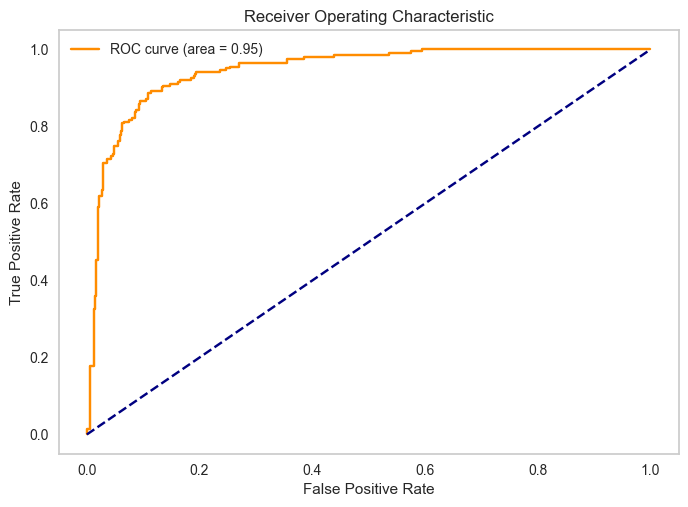

In [14]:


y_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()


In [19]:
model.save("saved_model/cnn_model.h5")
joblib.dump(scaler, 'saved_model/cnn_scaler.pkl')


C:\Users\COMPUTER WISA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['saved_model/cnn_scaler.pkl']

In [20]:

model = load_model("saved_model/cnn_model.h5")
scaler = joblib.load("saved_model/cnn_scaler.pkl")
# Data input
user_input = pd.DataFrame([
    {'Pregnancies': 3, 'Glucose': 78, 'BloodPressure': 50, 'SkinThickness': 32, 'Insulin': 88, 'BMI': 31.0, 'DiabetesPedigreeFunction': 0.848, 'Age': 26},
    {'Pregnancies': 1, 'Glucose': 165, 'BloodPressure': 69, 'SkinThickness': 8,  'Insulin': 68, 'BMI': 23.9, 'DiabetesPedigreeFunction': 0.66,  'Age': 22},
    {'Pregnancies': 5, 'Glucose': 115, 'BloodPressure': 72, 'SkinThickness': 35, 'Insulin': 130, 'BMI': 36.2, 'DiabetesPedigreeFunction': 0.35, 'Age': 40},
    {'Pregnancies': 9, 'Glucose': 120, 'BloodPressure': 72, 'SkinThickness': 22, 'Insulin': 56,  'BMI': 20.8, 'DiabetesPedigreeFunction': 0.733,   'Age': 48},
    {'Pregnancies': 4, 'Glucose': 180, 'BloodPressure': 85, 'SkinThickness': 29, 'Insulin': 150, 'BMI': 34.3, 'DiabetesPedigreeFunction': 0.2, 'Age': 33},
])

# Transform log
cols_to_log = ["Insulin", "DiabetesPedigreeFunction", "Age", "Pregnancies"]
for col in cols_to_log:
    user_input[col] = np.log1p(user_input[col])

# Tambahkan dummy column agar jumlah fitur = 9 (sama seperti saat training)
user_input['dummy_0'] = 0

# Urutkan kolom agar sesuai dengan training
ordered_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                   'BMI', 'DiabetesPedigreeFunction', 'Age', 'dummy_0']
user_input = user_input[ordered_columns]

# Scaling
user_input_scaled = scaler.transform(user_input)

# Reshape ke format CNN
user_input_reshaped = user_input_scaled.reshape(-1, 3, 3, 1)

# Load dan prediksi

predictions = model.predict(user_input_reshaped)

# Tampilkan hasil
for i, p in enumerate(predictions):
    print(f"Data ke-{i+1} -> Probabilitas Diabetes: {p[0]*100:.2f}%")


1/1 [==============================] - 0s 56ms/step
Data ke-1 -> Probabilitas Diabetes: 12.61%
Data ke-2 -> Probabilitas Diabetes: 42.37%
Data ke-3 -> Probabilitas Diabetes: 19.85%
Data ke-4 -> Probabilitas Diabetes: 15.10%
Data ke-5 -> Probabilitas Diabetes: 88.33%
